In [2]:
#Disclaimer ----------------------------------------------------------
#---------------------------------------------------------------------
#This code for learning purpose only 
#it may or may not give you high accuracy required for competition .
#if you found any error and increase the accuracy please mail me ,if you can.
#since i dont have GPU to train u used my laptop 
#----------------------------------------------------------------------
import idx2numpy as idx
import numpy as np
import os
import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
from random import shuffle
import time

from datetime import timedelta


#tensorflow import
import tensorflow as tf

In [3]:
#import data from directory
path="Data/"

data_set = []

number_classes = 10
for each_file in os.listdir(path) :
    data_set.append(idx.convert_from_file(path+each_file))
test_x,test_y,train_x,train_y = data_set[0],data_set[1],data_set[2],data_set[3]

In [4]:
def hot_encoding(labels,classes):
    return np.eye(classes)[labels].astype(np.float32)        

In [5]:
is_tf = True
if is_tf:
    shape=[-1,28,28,1]
else:
    shape = [-1,1,28,28]

X_train = np.reshape(train_x,shape).astype('float32')
X_test = np.reshape(test_x,shape).astype('float32')
X_train = X_train/255
X_test = X_test/255
#convert label in to one hot encoded array
y_train = hot_encoding(train_y,10)
y_test = hot_encoding(test_y,10)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000, 10), (10000, 10))

In [153]:
flatten_x = np.reshape(train_x,(-1,784))
pca = PCA(n_components=2)
pca_train_x = pca.fit_transform(flatten_x)

In [154]:
def plot_graph(data,label):
    colors = ['red','green','blue','purple','yellow','pink','orange','brown','black','gray']
    fig = plt.figure(figsize=(8,8))
    plt.scatter(data[:,0],data[:,1],c=label,
            cmap=matplotlib.colors.ListedColormap(colors),marker='o',s=50)
    cb = plt.colorbar()
    loc = np.arange(0,max(label),max(label)/float(len(colors)))
    cb.set_ticks(loc)
    cb.set_ticklabels(label)

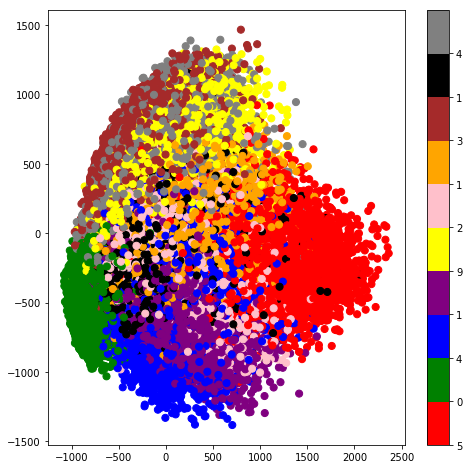

In [155]:
plot_graph(pca_train_x,train_y)
plt.show()

In [7]:
#pca = PCA(n_components=50)
#pca_train_x1 = pca.fit_transform(flatten_x)
#tsne =TSNE(n_components=2,verbose=1,perplexity=40,n_iter=300)
#tsne_result = tsne.fit_transform(pca_train_x1)
#plot_graph(tsne_result,train_y)
#plt.show()

# Classification with Tensor Flow


In [156]:
def new_weight_biases(shape,length):
    return {'weights':tf.Variable(tf.random_normal(shape)),
            'biases':tf.Variable(tf.constant(0.05,shape=[length]))}


In [157]:
def show_image(image,true_label,predicted_label_,img_number):
    X_test = np.reshape(image,[-1,28,28])
    im_number = img_number
    plt.imshow(X_test[im_number])
    plt.show()
    t_label = np.argmax(true_label[im_number])
    p_label = predicted_label_[im_number]
    print(t_label,p_label)
    print("*** True label of image "+str(im_number)+" is*** "+str(t_label)+" and prediction "+str(p_label))

## Declaring variable and placeholder for both network

In [162]:
nodes_layer1=500 #number of nodes in each layer
nodes_layer2=500
nodes_layer3=500

n_classes=10
batch_size_=100
Image_size = 28

x=tf.placeholder(tf.float32,[None,Image_size*Image_size])
y=tf.placeholder(tf.float32,[None,10])


# variables for convnet 
filter_1 = 32 #filter_size
filter_2 = 64 #filter_size

fc_size = 64 #nodes in fully connected layer
fc_size2 = 128

number_channels = 1

input_tensor = tf.placeholder(tf.float32,shape=[None,Image_size,Image_size,number_channels], name='x')
output_tensor = tf.placeholder(tf.float32,shape=[None,10],name='y')

## Model with only Three Dense Layer

In [163]:
def neural_network_model():
    
    #First layer
    hidden_1_layer = new_weight_biases([784,nodes_layer1],nodes_layer1)
    l1=tf.add(tf.matmul(x,hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1=tf.nn.relu(l1)
    
    #second layer
    hidden_2_layer = new_weight_biases([nodes_layer1,nodes_layer2],nodes_layer2)
    l2=tf.add(tf.matmul(l1,hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2=tf.nn.relu(l2)
    
    #third layer
    hidden_3_layer = new_weight_biases([nodes_layer2,nodes_layer3],nodes_layer3)
    l3=tf.add(tf.matmul(l2,hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3=tf.nn.relu(l3)
    
    #output layer
    output_layer = new_weight_biases([nodes_layer3,n_classes],n_classes)
    output=tf.matmul(l3,output_layer['weights'])+ output_layer  ['biases']
    
    return output

## Model with 2 Convolutional  layer and 2 Dense Layer

In [185]:
def tensor_flow_network(is_training):
    #convolution layer 1 with 16 filter of size 3*3
    cl1_w_b = new_weight_biases([3,3,number_channels,filter_1],filter_1)
    conv_layer1 = tf.nn.conv2d(input_tensor,cl1_w_b['weights'],strides=[1,1,1,1],padding='SAME') + cl1_w_b['biases']
    conv_output_1 = tf.nn.relu(conv_layer1)
    max_pool_layer1 = tf.nn.max_pool(conv_output_1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    #convolution layer 2 with 32 filter of size 5*5
    cl2_w_b = new_weight_biases([5,5,filter_1,filter_2],filter_2)
    conv_layer2 = tf.nn.conv2d(max_pool_layer1,cl2_w_b['weights'],strides=[1,1,1,1],padding='SAME')+cl2_w_b['biases']
    conv_output_2 = tf.nn.relu(conv_layer2)
    max_pool_layer2 = tf.nn.max_pool(conv_output_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    #Flatten the output of convolution layer for fully connected layer
    layer_shape = max_pool_layer2.get_shape()
    num_features = layer_shape[1:4].num_elements()
    flatten_layer = tf.reshape(max_pool_layer2,[-1,num_features])
    
    #fully connected layer with 64 nodes
    fc1_w_b = new_weight_biases([num_features,fc_size],fc_size)
    fc_layer_1 = tf.matmul(flatten_layer,fc1_w_b['weights'])+fc1_w_b['biases']
    fc_output_1 = tf.nn.relu(fc_layer_1)
    
    if is_training:
        fc_output_1 = tf.nn.dropout(fc_output_1,0.5)
    
    #fully connected layer with 128 nodes
    fc2_w_b = new_weight_biases([fc_size,fc_size2],fc_size2)
    fc_layer_2 =tf.matmul(fc_output_1,fc2_w_b['weights'])+fc2_w_b['biases']
    fc_output_2= tf.nn.relu(fc_layer_2)
    
    if is_training:
        fc_output_2 = tf.nn.dropout(fc_output_2,0.5)
    
    #final output layer with softmax activation
    outputl_w_b = new_weight_biases([fc_size2,number_classes],number_classes)
    output_layer = tf.matmul(fc_output_2,outputl_w_b['weights'])+outputl_w_b['biases']
    
    return output_layer                   

## Training function for both network

In [186]:
def train_(is_convnet,train_data,test_data,train_labels,test_labels,_epoch,in_tensor,out_tensor):
    if is_convnet:
        prediction = tensor_flow_network(True)
        pred = tf.argmax(tensor_flow_network(False),axis=1)
    else:
        prediction= neural_network_model()
        pred = tf.argmax(prediction,axis=1)
    
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=out_tensor) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    epochs=_epoch
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print("training...............................................................")
        start_time = time.time()
    
        
        for epoch in range(epochs):
            epoch_loss=0
            batch = 0
            len_data = len(train_data)
            while batch < len_data:
                start = batch
                end = min(batch+batch_size_,len_data)
                batch_x = train_data[start:end]
                batch_y = train_labels[start:end]
                _,c=sess.run([optimizer,cost], feed_dict={in_tensor:batch_x,out_tensor:batch_y})
                epoch_loss+=c
                batch+=batch_size_
                
            end_time = time.time()
            difference = end_time - start_time
            print("Time usage: " + str(timedelta(seconds=int(round(difference)))))
            print('Epoch',epoch+1,'completed out of ', epochs,'loss:',epoch_loss)
        print("---------------Training completed--------------------------------------")
        print("---------------Prediction----------------------------------------------")
        test_output = sess.run(pred,feed_dict={in_tensor:test_data})
        correct = np.equal(test_output,np.argmax(test_labels,1))
        accuracy = np.mean(correct.astype('float'))
        print('Prediction accuracy is :',accuracy*100,"%") 
        return test_output

## Train and predict Convolution network

In [187]:
predicted_label_convnet = train_(True,X_train,X_test,y_train,y_test,10,input_tensor,output_tensor)

training...............................................................
Time usage: 0:00:46
Epoch 1 completed out of  10 loss: 4373659.84272
Time usage: 0:01:32
Epoch 2 completed out of  10 loss: 8065.91273975
Time usage: 0:02:17
Epoch 3 completed out of  10 loss: 3551.95663476
Time usage: 0:03:03
Epoch 4 completed out of  10 loss: 2325.90758896
Time usage: 0:03:49
Epoch 5 completed out of  10 loss: 1912.81290865
Time usage: 0:04:35
Epoch 6 completed out of  10 loss: 1528.70337582
Time usage: 0:05:21
Epoch 7 completed out of  10 loss: 1407.95766449
Time usage: 0:06:07
Epoch 8 completed out of  10 loss: 1525.95741963
Time usage: 0:06:53
Epoch 9 completed out of  10 loss: 1387.80926681
Time usage: 0:07:39
Epoch 10 completed out of  10 loss: 1380.74287224
---------------Training completed--------------------------------------
---------------Prediction----------------------------------------------
Prediction accuracy is : 2.37 %


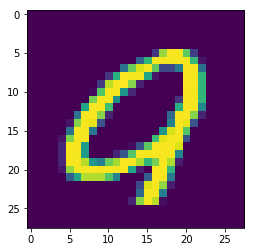

9 1
*** True label of image 6505 is*** 9 and prediction 1


In [188]:
#prediction
show_image(X_test,y_test,predicted_label_convnet,6505)

## if you find out whats wrong with this network , please mail me . 
ali9457@outlook.com

## Train Dense layer network

In [189]:
predicted_label = train_(False,X_train.reshape([-1,784]),X_test.reshape([-1,784]),y_train,y_test,20,x,y) 

training...............................................................
Time usage: 0:00:07
Epoch 1 completed out of  20 loss: 1710005.28605
Time usage: 0:00:14
Epoch 2 completed out of  20 loss: 432582.866203
Time usage: 0:00:21
Epoch 3 completed out of  20 loss: 224534.479037
Time usage: 0:00:27
Epoch 4 completed out of  20 loss: 132840.342716
Time usage: 0:00:35
Epoch 5 completed out of  20 loss: 84653.8343234
Time usage: 0:00:42
Epoch 6 completed out of  20 loss: 54841.981841
Time usage: 0:00:49
Epoch 7 completed out of  20 loss: 39843.7737071
Time usage: 0:00:56
Epoch 8 completed out of  20 loss: 29922.5384857
Time usage: 0:01:02
Epoch 9 completed out of  20 loss: 23818.7729024
Time usage: 0:01:09
Epoch 10 completed out of  20 loss: 24089.5623071
Time usage: 0:01:16
Epoch 11 completed out of  20 loss: 16792.7233385
Time usage: 0:01:23
Epoch 12 completed out of  20 loss: 16543.7185813
Time usage: 0:01:30
Epoch 13 completed out of  20 loss: 15396.3196017
Time usage: 0:01:38
Epoch 14

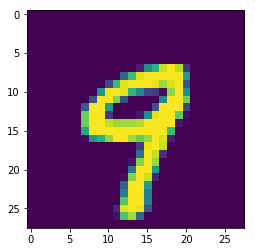

9 9
*** True label of image 8705 is*** 9 and prediction 9


In [190]:
#prediction
show_image(X_test,y_test,predicted_label,8705)

# Classification with keras (theano backend)

In [15]:
from keras.models import Sequential
from keras.layers.core import Dense,Flatten,Dropout
from keras.layers.convolutional import Convolution2D,MaxPooling2D
from keras.optimizers import Adadelta
from keras.preprocessing import image

In [16]:
def convolution2d(model,filters,k,layers):
    for layer in range(layers):
        if layer == 0:
            model.add(Convolution2D(32,3,3,activation='relu',input_shape=(1,28,28)))
        else:
            model.add(Convolution2D(filters,k,k,activation='relu'))
        model.add(MaxPooling2D((2,2),strides=(2,2)))

def FullyConnected(model,fc,drop_out):
    for size,d_out in zip(fc,drop_out):
        if d_out:
            model.add(Dense(size,activation='relu'))
            model.add(Dropout(0.5))
        else:
            model.add(Dense(size,activation='softmax'))
    
def keras_network():
    filters = 64
    k = 5
    
    model = Sequential()
    # two layer of convolution with 32 and 64 filters 
    convolution2d(model,filters,k,2)
    #  Flatten all output from convolution for dense layer
    model.add(Flatten())
    # two dense layer wiht 64 and 128 nodes and output layer 
    FullyConnected(model,[64,128,10],[True,True,False])
    
    model.compile(Adadelta(),loss='categorical_crossentropy',metrics=['accuracy'])
    return model
    
    

In [17]:
model = keras_network()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 26, 26)    320         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 32, 13, 13)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 64, 9, 9)      51264       maxpooling2d_3[0][0]             
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 64, 4, 4)      0           convolution2d_4[0][0]            
___________________________________________________________________________________________

In [19]:
model.fit(X_train,y_train,batch_size=64,nb_epoch=1,verbose=10,validation_data=(X_test,y_test))
scores = model.evaluate(X_test, y_test, verbose=0)
print(" Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 Error: 2.94%


In [20]:
model.metrics_names,scores

(['loss', 'acc'], [0.099276268604863438, 0.97060000000000002])

In [22]:
prdiction = model.predict(X_test)
print("------------prediction done----------")

------------prediction done----------


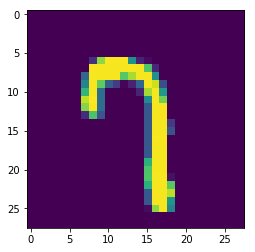

7 7
*** True label of image 1496 is*** 7 and prediction 7


In [192]:
#prediction
show_image(X_test,y_test,prdiction,1496)